In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train = pd.read_csv("/home/rmungalov/Simulator/Skillfactory/Heart_Disease_AI/train.csv")
test = pd.read_csv("/home/rmungalov/Simulator/Skillfactory/Heart_Disease_AI/test.csv")

In [3]:
print("=== HEAD ===")
print(train.head())

print("\n=== INFO ===")
print(train.info())

print("\n=== NULLS ===")
print(train.isnull().sum())

=== HEAD ===
   ID        age  sex     chest  resting_blood_pressure  serum_cholestoral  \
0   0  49.207124    0  4.000000              162.996167         181.108682   
1   1  53.628425    1  1.741596              130.233730         276.474630   
2   2  49.591426    1  4.000000              146.999012         223.300517   
3   3  58.991445    1  4.000000              112.369143         187.245501   
4   4  51.053602    1  1.954609              138.032047         238.482868   

   fasting_blood_sugar  resting_electrocardiographic_results  \
0                    0                                     0   
1                    0                                     2   
2                    1                                     2   
3                    0                                     0   
4                    0                                     0   

   maximum_heart_rate_achieved  exercise_induced_angina   oldpeak  slope  \
0                   148.227858                        1  

# Preprocessing

In [4]:
# === Preprocessing ===

# Drop NaN
train = train.dropna()
test = test.dropna()

# Drop impossibilities
train = train[
    (train['age'] > 0) &
    (train['resting_blood_pressure'] > 0) &
    (train['serum_cholestoral'] > 0) &
    (train['maximum_heart_rate_achieved'] > 0)
]

# Drop ID
test_ids = test["ID"]
train.drop(columns=["ID"], inplace=True)
test.drop(columns=["ID"], inplace=True)

# Categoricals
categorical_cols = ['sex', 'chest', 'fasting_blood_sugar', 'resting_electrocardiographic_results',
                    'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

# Rounding up
for col in categorical_cols:
    train[col] = train[col].round(0).astype("Int64")
    test[col] = test[col].round(0).astype("Int64")

# Categorization
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Trash filtration
safe_cats = [col for col in categorical_cols if train[col].nunique() < 10]

# One-hot encoding
train = pd.get_dummies(train, columns=safe_cats, drop_first=True)
test = pd.get_dummies(test, columns=safe_cats, drop_first=True)

# Train/test synchronization
test = test.reindex(columns=train.drop(columns=["class"]).columns, fill_value=0)

# Targeting
target_col = "class"
X = train.drop(columns=[target_col])
y = train[target_col]
X_test = test

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Analysis

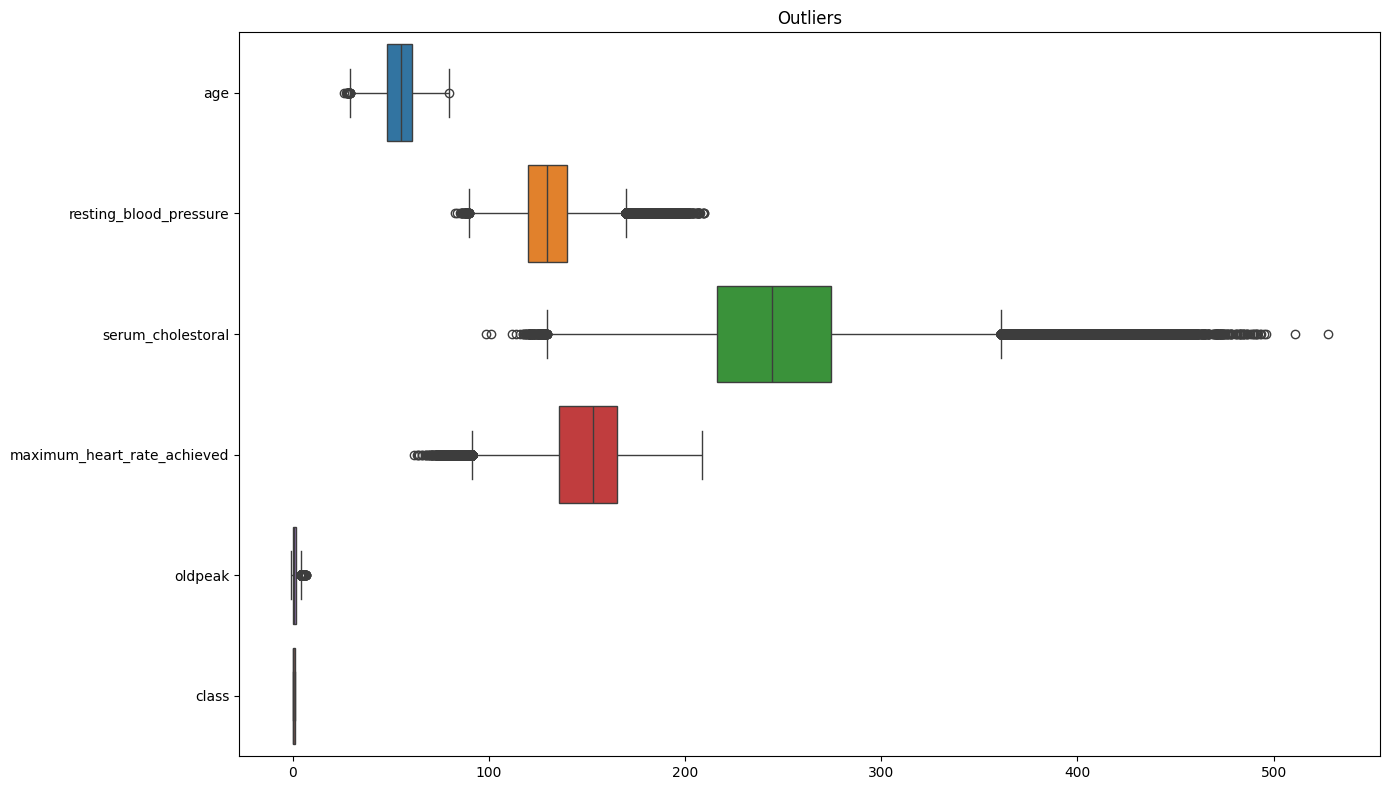

In [5]:
# Only numericals
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(data=train[numeric_cols], orient="h")
plt.title("Outliers")
plt.tight_layout()
plt.show()

                 age  resting_blood_pressure  serum_cholestoral  \
count  600000.000000           600000.000000      600000.000000   
mean       54.426085              131.340485         249.592420   
std         9.086041               17.842450          51.699976   
min        26.061695               82.918527          98.326263   
25%        48.078493              119.924094         216.475964   
50%        55.133425              129.727941         244.233699   
75%        60.663775              139.915216         274.345453   
max        79.591647              209.673650         527.755764   

       maximum_heart_rate_achieved        oldpeak          class  
count                600000.000000  600000.000000  600000.000000  
mean                    149.592069       1.051391       0.444185  
std                      23.072593       1.144288       0.496875  
min                      61.844168      -0.806788       0.000000  
25%                     135.704237       0.000000       0.000

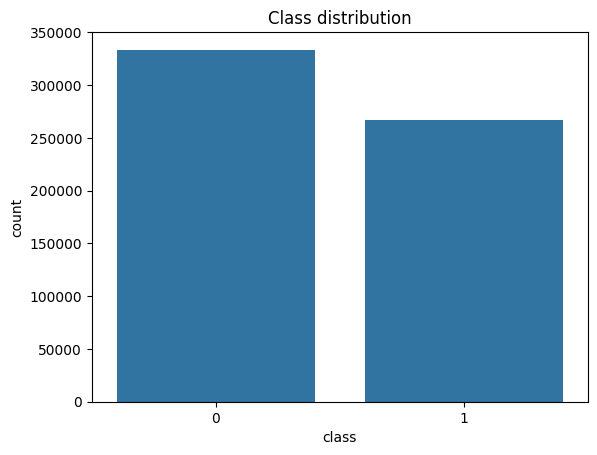

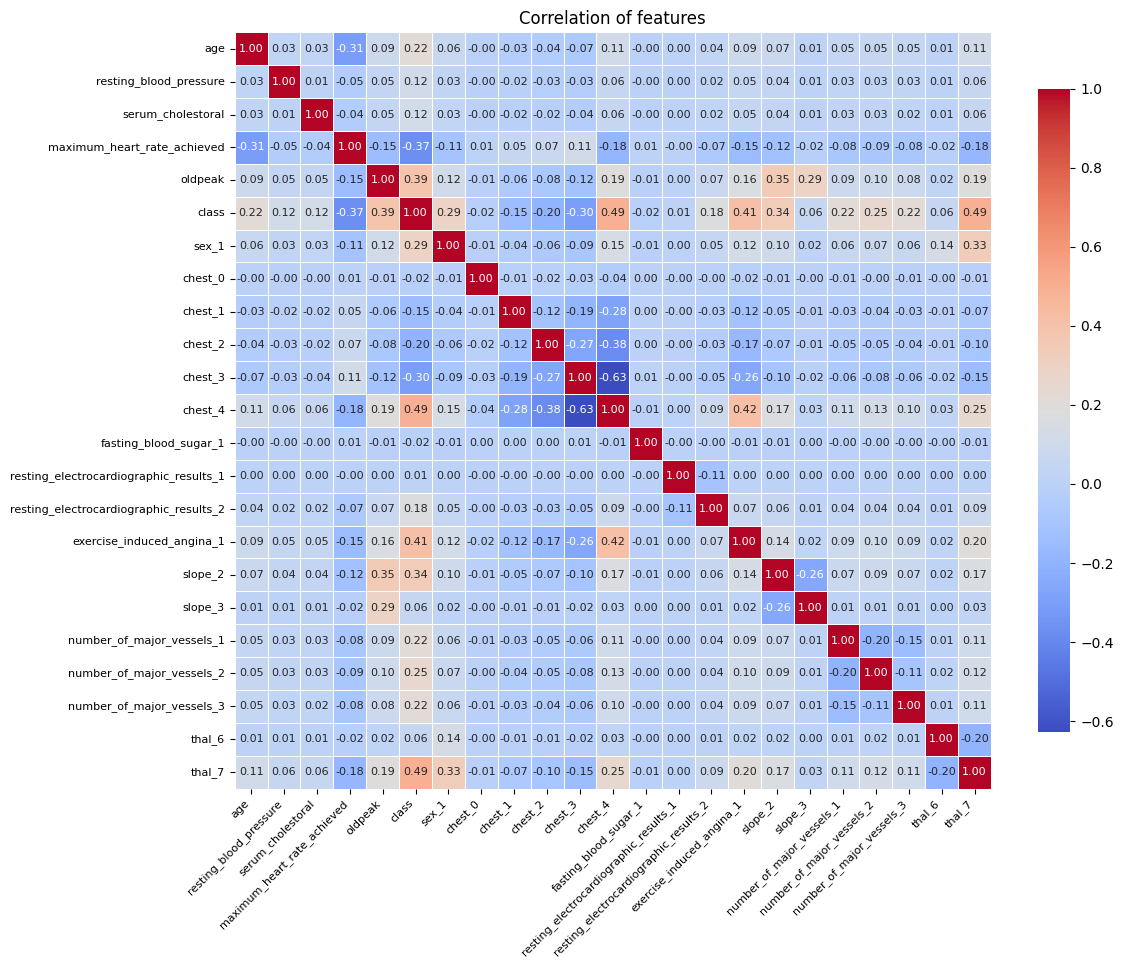

In [6]:
# Class distribution
print(train.describe())
print(train[target_col].value_counts())

# Bar plotting
sns.countplot(x=target_col, data=train)
plt.title("Class distribution")
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = train.corr()

# Строим heatmap с меньшими числами (меньше шрифт)
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}  # 👈 уменьшенный шрифт в ячейках
)

plt.title("Correlation of features")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

Among all features, maximum_heart_rate_achieved exhibits the strongest negative correlation (-0,37) with the target variable *class*, suggesting that lower heart rate performance is associated with a higher likelihood of cardiac risk. In contrast, thal shows the highest positive correlation (0,49) with *class*, indicating that abnormalities detected by the thallium stress test are strong predictors of disease presence. This highlights the importance of both exercise tolerance and imaging results in determining cardiovascular health.

The **thallium stress** test is a type of nuclear imaging used to evaluate blood flow to the heart during exercise or pharmacological stress. It helps detect regions with poor perfusion, making it a strong non-invasive indicator of coronary artery disease — which explains its high correlation with the heart disease outcome.

## Logistic Regression

In [7]:
# Split train to train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_val_pred_log = logreg.predict(X_val)
y_val_proba_log = logreg.predict_proba(X_val)[:, 1]

print("=== Logistic Regression metrics on validation ===")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred_log):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_log):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_pred_log):.4f}")
print(f"F1-score:  {f1_score(y_val, y_val_pred_log):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val, y_val_proba_log):.4f}\n")

=== Logistic Regression metrics on validation ===
Accuracy:  0.8891
Precision: 0.8833
Recall:    0.8645
F1-score:  0.8738
ROC AUC:   0.9557



## Random Forest

In [8]:
# Random Forest (not scaled)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)
y_val_pred_rf = rf.predict(X_val_rf)
y_val_proba_rf = rf.predict_proba(X_val_rf)[:, 1]

print("=== Random Forest metrics on validation ===")
print(f"Accuracy:  {accuracy_score(y_val_rf, y_val_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val_rf, y_val_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_val_rf, y_val_pred_rf):.4f}")
print(f"F1-score:  {f1_score(y_val_rf, y_val_pred_rf):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val_rf, y_val_proba_rf):.4f}")

=== Random Forest metrics on validation ===
Accuracy:  0.8969
Precision: 0.8908
Recall:    0.8752
F1-score:  0.8829
ROC AUC:   0.9594


On average, the random forest performs better on key metrics

## Neural Network

In [9]:
# 1. Split to train/val
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42, stratify=y)

# 2. Conversion to tensors
X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_nn, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)

# 3. Architecture
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. Learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

# 5. Metrics validation
model.eval()
with torch.no_grad():
    y_val_preds_proba = model(X_val_tensor.to(device)).cpu().numpy()
    y_val_preds = (y_val_preds_proba > 0.5).astype(int)

# Result
print("\n=== Neural Network metrics on validation ===")
print(f"Accuracy:  {accuracy_score(y_val_nn, y_val_preds):.4f}")
print(f"Precision: {precision_score(y_val_nn, y_val_preds):.4f}")
print(f"Recall:    {recall_score(y_val_nn, y_val_preds):.4f}")
print(f"F1-score:  {f1_score(y_val_nn, y_val_preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val_nn, y_val_preds_proba):.4f}")

Epoch 1/10 - Loss: 0.2716
Epoch 2/10 - Loss: 0.2597
Epoch 3/10 - Loss: 0.2579
Epoch 4/10 - Loss: 0.2560
Epoch 5/10 - Loss: 0.2541
Epoch 6/10 - Loss: 0.2533
Epoch 7/10 - Loss: 0.2526
Epoch 8/10 - Loss: 0.2519
Epoch 9/10 - Loss: 0.2516
Epoch 10/10 - Loss: 0.2514

=== Neural Network metrics on validation ===
Accuracy:  0.8981
Precision: 0.8944
Recall:    0.8738
F1-score:  0.8839
ROC AUC:   0.9619


In [10]:
# === Enhanced architecture ===
class ImprovedNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)  # без сигмоида
        )

    def forward(self, x):
        return self.net(x)

# === Learning ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedNet(X_train_tensor.shape[1]).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1:02d}/{n_epochs} - Loss: {total_loss / len(train_loader):.4f}")

# === Metrics validation ===
model.eval()
with torch.no_grad():
    val_logits = model(X_val_tensor.to(device)).cpu()
    val_probs = torch.sigmoid(val_logits).numpy()
    val_preds = (val_probs > 0.5).astype(int)

print("\n=== Improved Neural Network — Validation Metrics ===")
print(f"Accuracy:  {accuracy_score(y_val, val_preds):.4f}")
print(f"Precision: {precision_score(y_val, val_preds):.4f}")
print(f"Recall:    {recall_score(y_val, val_preds):.4f}")
print(f"F1-score:  {f1_score(y_val, val_preds):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_probs):.4f}")

# === Prediction ===
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

with torch.no_grad():
    test_logits = model(X_test_tensor.to(device)).cpu()
    test_probs = torch.sigmoid(test_logits).numpy()
    test_preds = (test_probs > 0.5).astype(int).flatten()

# === Submit ===
submission = pd.DataFrame({
    "ID": test_ids,
    "class": test_preds
})

print("\n=== Submit ===")
print(submission.head(10))

import os
os.makedirs("models", exist_ok=True)

torch.save(model.state_dict(), "models/best_model.pt")

import joblib
joblib.dump(scaler, "models/scaler.pkl")

Epoch 01/20 - Loss: 0.2686
Epoch 02/20 - Loss: 0.2587
Epoch 03/20 - Loss: 0.2553
Epoch 04/20 - Loss: 0.2534
Epoch 05/20 - Loss: 0.2527
Epoch 06/20 - Loss: 0.2507
Epoch 07/20 - Loss: 0.2504
Epoch 08/20 - Loss: 0.2503
Epoch 09/20 - Loss: 0.2494
Epoch 10/20 - Loss: 0.2489
Epoch 11/20 - Loss: 0.2488
Epoch 12/20 - Loss: 0.2482
Epoch 13/20 - Loss: 0.2481
Epoch 14/20 - Loss: 0.2481
Epoch 15/20 - Loss: 0.2479
Epoch 16/20 - Loss: 0.2472
Epoch 17/20 - Loss: 0.2474
Epoch 18/20 - Loss: 0.2473
Epoch 19/20 - Loss: 0.2471
Epoch 20/20 - Loss: 0.2468

=== Improved Neural Network — Validation Metrics ===
Accuracy:  0.8994
Precision: 0.8932
Recall:    0.8786
F1-score:  0.8858
ROC AUC:   0.9627

=== Submit ===
       ID  class
0  600000      1
1  600001      1
2  600002      0
3  600003      0
4  600004      0
5  600005      1
6  600006      1
7  600007      0
8  600008      1
9  600009      0


['models/scaler.pkl']

## Monitoring an evolution of AUC

In [11]:
# === Learning with logging ===
train_losses = []
val_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

model = ImprovedNet(X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.BCEWithLogitsLoss()

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # === Metrics validation ===
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor.to(device)).cpu()
        val_probs = torch.sigmoid(val_logits).numpy()
        val_preds = (val_probs > 0.5).astype(int)

    val_metrics["accuracy"].append(accuracy_score(y_val, val_preds))
    val_metrics["precision"].append(precision_score(y_val, val_preds))
    val_metrics["recall"].append(recall_score(y_val, val_preds))
    val_metrics["f1"].append(f1_score(y_val, val_preds))
    val_metrics["auc"].append(roc_auc_score(y_val, val_probs))

    print(f"Epoch {epoch+1:02d} — Loss: {avg_loss:.4f} — AUC: {val_metrics['auc'][-1]:.4f}")

Epoch 01 — Loss: 0.2686 — AUC: 0.9597
Epoch 02 — Loss: 0.2583 — AUC: 0.9609
Epoch 03 — Loss: 0.2548 — AUC: 0.9616
Epoch 04 — Loss: 0.2531 — AUC: 0.9618
Epoch 05 — Loss: 0.2524 — AUC: 0.9619
Epoch 06 — Loss: 0.2504 — AUC: 0.9622
Epoch 07 — Loss: 0.2501 — AUC: 0.9622
Epoch 08 — Loss: 0.2499 — AUC: 0.9623
Epoch 09 — Loss: 0.2494 — AUC: 0.9623
Epoch 10 — Loss: 0.2494 — AUC: 0.9624
Epoch 11 — Loss: 0.2488 — AUC: 0.9625
Epoch 12 — Loss: 0.2481 — AUC: 0.9625
Epoch 13 — Loss: 0.2482 — AUC: 0.9626
Epoch 14 — Loss: 0.2478 — AUC: 0.9625
Epoch 15 — Loss: 0.2478 — AUC: 0.9626
Epoch 16 — Loss: 0.2474 — AUC: 0.9626
Epoch 17 — Loss: 0.2471 — AUC: 0.9627
Epoch 18 — Loss: 0.2471 — AUC: 0.9627
Epoch 19 — Loss: 0.2471 — AUC: 0.9627
Epoch 20 — Loss: 0.2468 — AUC: 0.9627


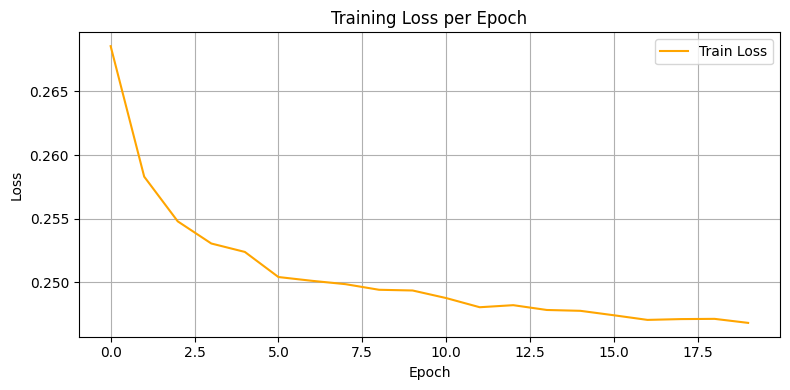

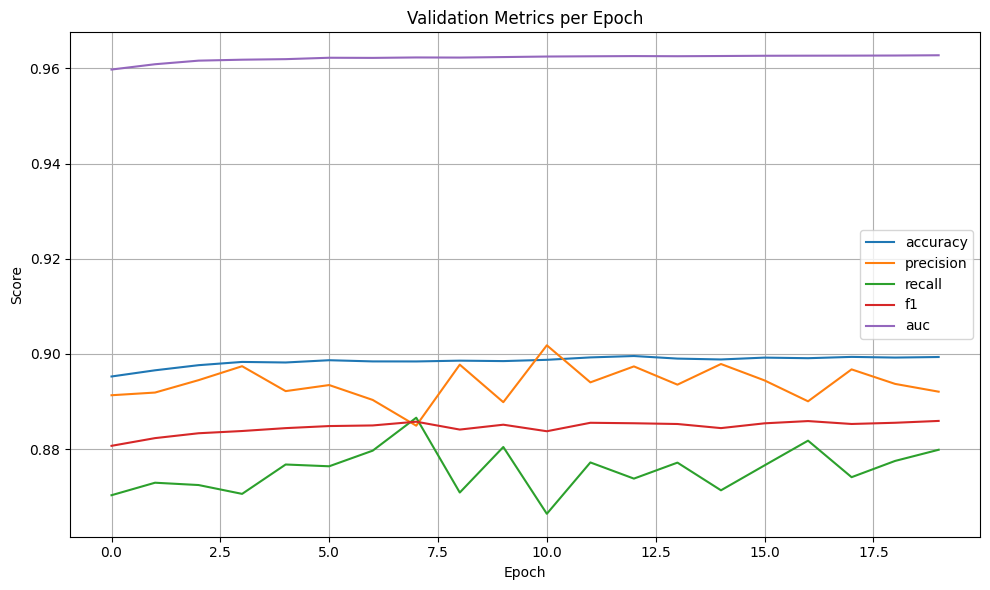

In [12]:
# === Loss graphs ===
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", color="orange")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print()

# === Metrics ===
plt.figure(figsize=(10, 6))
for metric, values in val_metrics.items():
    plt.plot(values, label=metric)
plt.title("Validation Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The loss graph shows a steady decrease in error.
- The metric validation graph by epoch also indicates an improvement in the model with the number of training iterations.

# Summary

| Модель              | Accuracy | Precision | Recall | F1-score | ROC AUC |
| ------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression | 0.8891   | 0.8834    | 0.8644 | 0.8738   | 0.9557  |
| Random Forest       | 0.8969   | 0.8908    | 0.8752 | 0.8829   | 0.9594  |
| Neural Network      | 0.8993   | 0.8912    | 0.8809 | 0.8860   | 0.9627  |

In this project, we explored a structured dataset containing cardiovascular features to predict the presence of heart disease (class variable). After preprocessing and exploratory data analysis, we trained and evaluated three models: Logistic Regression, Random Forest, and a custom-built Neural Network using PyTorch.

All models demonstrated solid performance, with Random Forest and Neural Network outperforming the baseline Logistic Regression in terms of accuracy, precision, and recall. The correlation matrix revealed key predictors such as maximum heart rate achieved, oldpeak, and thal, aligning with known clinical indicators of heart disease.

The Neural Network model delivered the highest overall performance, achieving the best F1-score (0,8860) and AUC (0,9627), suggesting it captures complex nonlinear relationships better than traditional algorithms. This confirms that even on tabular medical data, well-regularized neural networks can outperform classical methods when properly tuned and trained.

# Inference

In [13]:
# === Model and scaler upload
scaler = joblib.load("models/scaler.pkl")

# === Data upload
new_data = pd.read_csv("train.csv")
test_ids = new_data["ID"]
features = new_data.drop(columns=["ID", "class"], errors="ignore")

# === Preprocessing
categorical_cols = ['sex', 'chest', 'fasting_blood_sugar', 'resting_electrocardiographic_results',
                    'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

for col in categorical_cols:
    features[col] = features[col].round(0).astype("Int64")
    features[col] = features[col].astype("category")

safe_cats = [col for col in categorical_cols if features[col].nunique() < 10]
features = pd.get_dummies(features, columns=safe_cats, drop_first=True)

# === Model init (теперь features уже определён)
model = ImprovedNet(input_dim=features.shape[1])
model.load_state_dict(torch.load("models/best_model.pt", map_location="cpu"))
model.eval()

# === Scaling and tensor conversion
X_scaled = scaler.transform(features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# === Prediction
with torch.no_grad():
    logits = model(X_tensor)
    probs = torch.sigmoid(logits).numpy().flatten()
    preds = (probs > 0.5).astype(int)

# === Inference result
submission = pd.DataFrame({
    "ID": test_ids,
    "prediction": preds,
    "probability": probs
})

print(submission.head(10))

/scratch/ipykernel_442632/156278461.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/best_model.pt", map_location="cpu"))


   ID  prediction  probability
0   0           0     0.233021
1   1           0     0.031073
2   2           1     0.999567
3   3           1     0.909935
4   4           0     0.024253
5   5           0     0.016101
6   6           1     0.599011
7   7           0     0.031405
8   8           1     0.998985
9   9           0     0.011133


In [14]:
submission.to_csv("submission.csv", index=False)

In [15]:
import os

print("Model:", os.path.exists("models/best_model.pt"))
print("Scaler:", os.path.exists("models/scaler.pkl"))
print("Submit:", os.path.exists("submission.csv"))

Model: True
Scaler: True
Submit: True
